## Observations
1. Our gradient estimates at known sample locations are large when we resample at the sample location in our trajectory.

In [265]:
using LinearAlgebra
using Plots
using Random

In [266]:
include("../rollout.jl")
include("../testfns.jl")
include("../utils.jl")

stochastic_gradient_ascent_adam (generic function with 1 method)

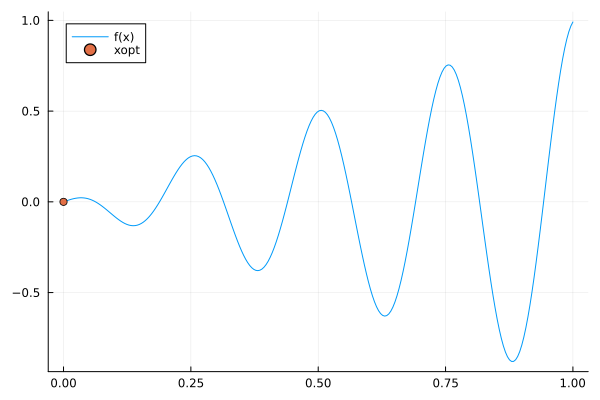

In [280]:
testfn = TestLinearCosine1D(1, 25, lb=0., ub=1)
# testfn = TestQuadratic1D(-1., 0., 0.; lb=-1., ub=1.)
# testfn = TestConstant(0., lbs=[0.], ubs=[1.])
# testfn = TestGramacyLee()
tplot(testfn)

In [284]:
Random.seed!(1234)

n, h, σn2 = 1, 0, 1e-6
MC_SAMPLES = 50
# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, h+1);
rns = randn(MC_SAMPLES, testfn.dim+1, h+1);
xmin, xmax, d = (testfn.bounds[1], testfn.bounds[2], size(testfn.bounds, 1))
θ = [1.]
ψ = kernel_matern52(θ)
# ψ = kernel_scale(kernel_matern52, [5., θ...])

lbs, ubs = [xmin], [xmax]
ϵ, num_starts = 1e-6, 16
s = SobolSeq(lbs, ubs)

xstarts = reduce(hcat, next!(s) for i = 1:num_starts)
xstarts = hcat(xstarts, lbs .+ ϵ)
xstarts = hcat(xstarts, ubs .- ϵ);

### Dense Experiments in 1D for Rollout Acquisition Functions
We'll do a comparative analysis, visually, of the structure of the rollout acquisition function in 1D for horizons 0 and 1.

In [287]:
X = [0.;; .05;; .1;; .3;; .35;; .8;;]
y = testfn(X)
sur = fit_surrogate(ψ, X, y; σn2=σn2)
sur = optimize_hypers_optim(sur, kernel_matern52)

discretization_length = 100
domain = collect(range(xmin, xmax, length=discretization_length))
w = 1e-8
variance_reduction = false

rollouts = zeros(discretization_length)
rollouts_stderr = zeros(discretization_length)
gradient_rollouts = zeros(discretization_length)
gradient_rollouts_stderr = zeros(discretization_length)
finite_difference_rollouts = zeros(discretization_length)

print("Rollout Evaluations: ")
# Dense Evaluation of Rollout Acquisition Function
for (i, x) in enumerate(domain)
    print("|")
    x0 = [x]
    sx = sur(x0)

    tp = TrajectoryParameters(
        x0=x0, h=h, mc_iters=MC_SAMPLES,
        rnstream_sequence=rns, lbs=lbs, ubs=ubs
    )
    # Monte-carlo integrate trajectory for x0
    μx, ∇μx, μ_stderr, ∇μ_stderr = simulate_trajectory(sur, tp, xstarts, variance_reduction=variance_reduction)
    # μx, ∇μx = simulate_trajectory_deterministic(sur, tp, xstarts, testfn=testfn)
    rollouts[i] = μx
    rollouts_stderr[i] = μ_stderr
    gradient_rollouts[i] = first(∇μx)
    gradient_rollouts_stderr[i] = ∇μ_stderr

    # Finite Difference Approximation of Gradients
    tp_plus = TrajectoryParameters(
        x0=x0 .+ w, h=h, mc_iters=MC_SAMPLES,
        rnstream_sequence=rns, lbs=lbs, ubs=ubs
    )
    tp_minus = TrajectoryParameters(
        x0=x0 .- w, h=h, mc_iters=MC_SAMPLES,
        rnstream_sequence=rns, lbs=lbs, ubs=ubs
    )
    μx_plus, trash = simulate_trajectory(sur, tp_plus, xstarts, variance_reduction=variance_reduction)
    μx_minus, trash = simulate_trajectory(sur, tp_minus, xstarts, variance_reduction=variance_reduction)
    # μx_plus, trash = simulate_trajectory_deterministic(sur, tp_plus, xstarts, testfn=testfn)
    # μx_minus, trash = simulate_trajectory_deterministic(sur, tp_minus, xstarts, testfn=testfn)
    finite_difference_rollouts[i] = (μx_plus - μx_minus) / 2w
end

Rollout Evaluations: ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [296]:
plot1D(sur; xmin=xmin, xmax=xmax, npts=200)
# plot!(domain, [testfn([x]) for x in domain], label="Underlying Function")
plot!(legend=false, xticks=[], yticks=[], framestyle=:none, dpi=900)

"/home/jamosa/Development/rollout_bayesian_optimization/notebooks/surrogate.png"

In [252]:
function build_mean(sur, x)
    dK = eval_∇KxX(ψ, x, sur.X)
    dmu = dK*sur.c
    ds = eval_Hk(sur.ψ, zeros(length(x))) - dK * (sur.K \ dK')
    
    return first(dmu), first(ds)
end

build_mean (generic function with 1 method)

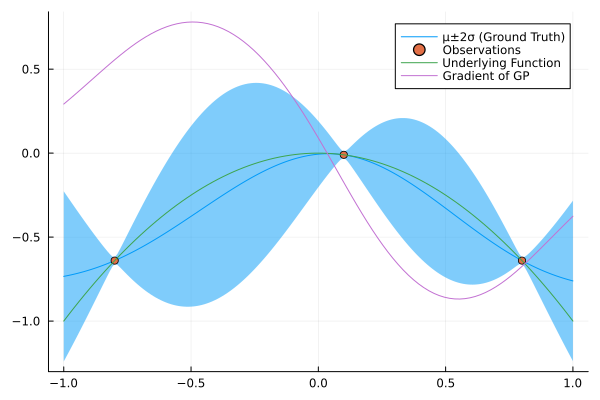

In [264]:
mus, sigmas = [], []

for x in domain
    mu, sigma = build_mean(sur, [x])
    
    push!(mus, mu)
    push!(sigmas, sigma)
end


plot1D(sur; xmin=xmin, xmax=xmax, npts=200)
plot!(domain, [testfn([x]) for x in domain], label="Underlying Function")
plot!(domain, mus, label="Gradient of GP")

In [176]:
zero_indices_analytic = find_zeros(gradient_rollouts);
zero_indices_fd = find_zeros(finite_difference_rollouts);

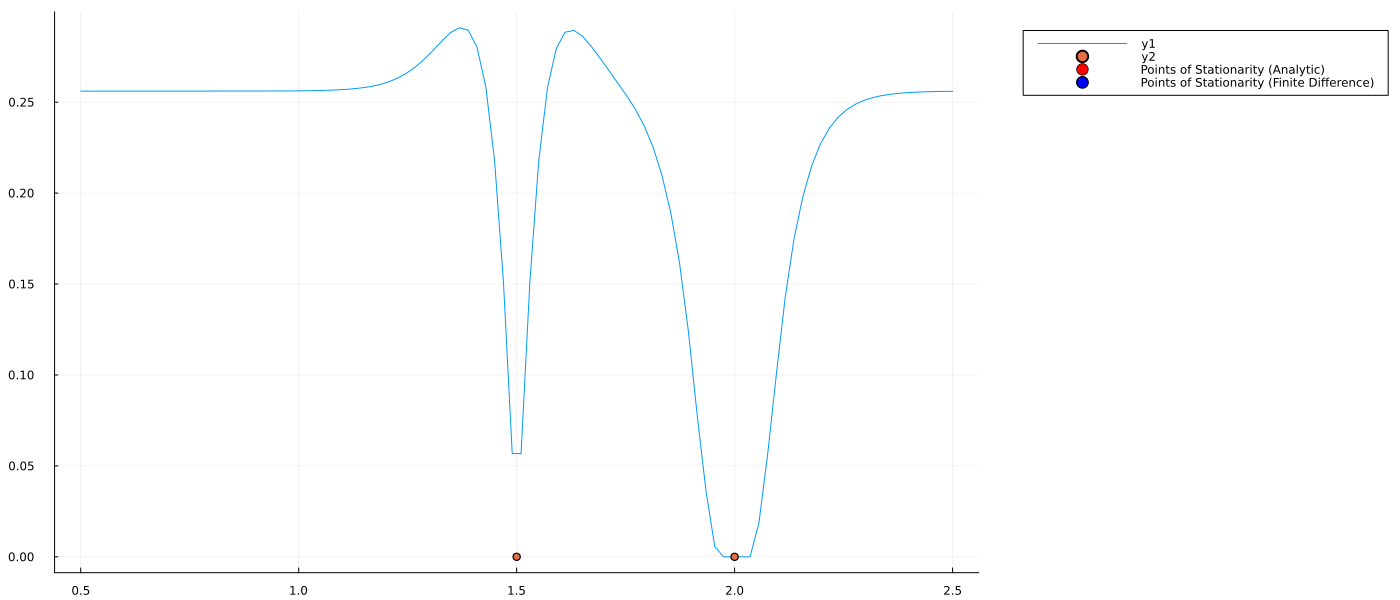

In [201]:
plot(domain, rollouts)
scatter!(sur.X', [0.])
scatter!(
    domain[zero_indices_analytic],
    rollouts[zero_indices_analytic],
    label="Points of Stationarity (Analytic)",
    legend=:outertopright,
    size=(1400, 600),
    color=:red,
    ms=10
)
scatter!(
    domain[zero_indices_fd],
    rollouts[zero_indices_fd],
    label="Points of Stationarity (Finite Difference)",
    color=:blue,
    ms=6
)

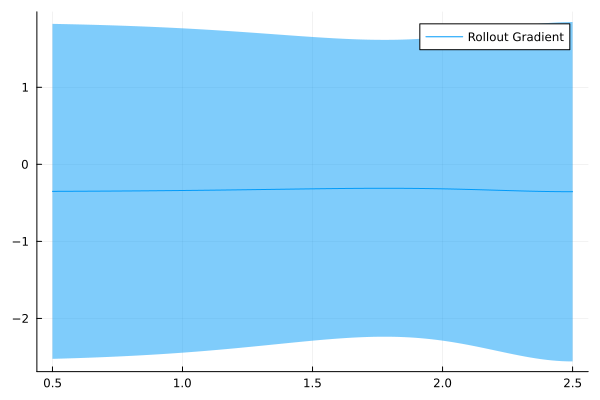

In [178]:
plot(domain, gradient_rollouts, label="Rollout Gradient", ribbons=gradient_rollouts_stderr)
# scatter!(domain[zero_indices_analytic], [0], ms=4, label="Roots")
# plot!(domain, finite_difference_rollouts, label="Finite Difference")
# plot!(domain, [first(sur([x]).∇EI) for x in domain], label="Analytic EI")

In [231]:
"""
TODO: We need to specify the maximum number of iterations and terminate if we exhaust our budget
TODO: EI for Rosenbrock looks like zeros everywhere, depending on how we sample. I suspect this
is why our algorithm halts here.
"""
function ei_solver(s::RBFsurrogate, lbs, ubs; initial_guesses, max_iterations=100)
    fbest = minimum(get_observations(s))

    function ei(x)
        sx = s(x)
        if sx.σ < 1e-6 return 0 end
        return -sx.EI
    end

    function ei_grad!(g, x)
        EIx = -s(x).∇EI
        for i in eachindex(EIx)
            g[i] = EIx[i]
        end
    end

    function ei_hessian!(h, x)
        HEIx = -s(x).HEI
        for row in 1:size(HEIx, 1)
            for col in 1:size(HEIx, 2)
                h[row, col] = HEIx[row, col]
            end
        end
    end

    final_minimizer = (initial_guesses[:, 1], Inf)
    
    for j in 1:size(initial_guesses, 2)
        initial_guess = initial_guesses[:, j]
        df = TwiceDifferentiable(ei, ei_grad!, ei_hessian!, initial_guess)
        dfc = TwiceDifferentiableConstraints(lbs, ubs)
        result = optimize(df, dfc, initial_guess, IPNewton(), Optim.Options(iterations=max_iterations))
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)

        if cur_minimum < final_minimizer[2]
            final_minimizer = (cur_minimizer, cur_minimum)
        end
    end
    
    return final_minimizer
end

# Initialize surrogate model
Xinit = [1.5;; 2.0;;]
yinit = testfn(Xinit)
sur_ei = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
sur_ei = optimize_hypers_optim(sur_ei, kernel_matern52)
BUDGET = 50
surs = []

# Perform Bayesian optimization iterations
print("Budget Counter: ")
for budget in 1:BUDGET
    print("|")
    # Solve the acquisition function
    xnext, fnext = ei_solver(sur_ei, lbs, ubs; initial_guesses=xstarts)
    ynext = testfn(xnext)
    # Update the surrogate model
    sur_ei = update_surrogate(sur_ei, xnext, ynext)
    sur_ei = optimize_hypers_optim(sur_ei, kernel_matern52)
    push!(surs, sur_ei)
end

Budget Counter: ||||||||||||||||||||||||||||||||||||||||||||||||||

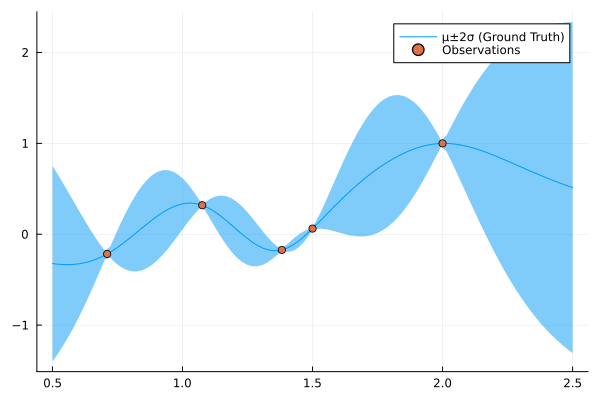

In [235]:
plot1D(surs[3], xmin=xmin, xmax=xmax)

In [233]:
fopt, xopt_index = findmin(get_observations(sur_ei))
sur_ei.X[:, xopt_index]

1-element Vector{Float64}:
 0.7488844140433265

In [234]:
sur_ei.X'

52×1 adjoint(::Matrix{Float64}) with eltype Float64:
 1.5
 2.0
 1.3820025712636417
 0.7103012986549271
 1.07588363399012
 0.5000000000000002
 2.4999999999999996
 0.8190826407296709
 0.6387408192985444
 1.2838477759259257
 0.7433767154406857
 1.6666375193741478
 1.814707109950768
 ⋮
 0.7489185073970884
 0.7489194487174814
 0.7489203524306339
 0.7489212268949126
 0.7489220730779328
 0.748922892512614
 0.7489236874640772
 0.7489244621690637
 0.7489252739817385
 2.3138829324751984
 0.7489596523441602
 0.7489594641217697

In [217]:
testfn.xopt

([0.548563],)

In [ ]:
tplot(testfn)

In [ ]:
X = [0.;; .8;;]
npts = size(X, 2)
δXdemo = rand(1, npts)
h = 1e-5
y = [testfn.f(X[:,j]) for j in 1:size(X, 2)]
∇y = [testfn.∇f(X[:,j]) for j in 1:size(X, 2)]

s  = fit_surrogate(ψ, X, y)
sp = fit_surrogate(ψ, X + h*δXdemo, y)
sm = fit_surrogate(ψ, X - h*δXdemo, y)

fs = fit_fsurrogate(s, 0)
fsp = fit_fsurrogate(sp, 0)
fsm = fit_fsurrogate(sm, 0)
δfs = fit_δsurrogate(fs, δXdemo, ∇y)

In [ ]:
plot(domain, [s([x]).EI for x in domain], label="EI")
plot!(domain, [sp([x]).EI for x in domain], label="EI + h")
plot!(domain, [sm([x]).EI for x in domain], label="EI - h")

In [ ]:
xn = [0.2712471165977242]
(fsp(xn).EI - fsm(xn).EI) / 2h

In [ ]:
fsx = fs(xn)
δfsx = δfs(fsx);
δfsx.EI

In [ ]:
xopt, _ = ei_solver(s, lbs, ubs; initial_guesses=xstarts)
xoptp, _ = ei_solver(sp, lbs, ubs; initial_guesses=xstarts)
xoptm, _ = ei_solver(sm, lbs, ubs; initial_guesses=xstarts)

In [ ]:
(xoptp - xoptm) / 2h

In [ ]:
-fsx.HEI \ δfsx.∇EI

In [ ]:
δfs.ymean